In [1]:
from math import sin
from math import pi
import numpy as np
from numpy import vstack
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import arange
from numpy import argmax
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
# the objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

In [3]:
# defining a grid based sample of the domain [0,1]
X = np.arange(0,1,0.01)

In [4]:
# sample the domain without noise
y  = [objective(x, 0) for x in X]

In [5]:
# sample the domain with noise
ynoise = [objective(x) for x in X]

In [6]:
# find the best result
xi = argmax(y)
print(f"Optimal: x = {X[xi]}, y = {y[xi]}")

Optimal: x = 0.9, y = 0.81


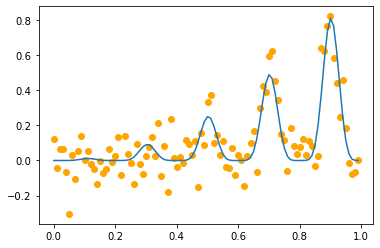

In [7]:
# plot the points with noise
plt.scatter(X, ynoise, c='orange')
plt.plot(X, y)
plt.show()

In [8]:
# Surrogate Function
# transforms input examples into output score
# probabilistically it is the conditional probability of an 
# objective function(f), given the available data (D) or
# P(f|D)

# Define the model
model = GaussianProcessRegressor()

In [9]:
# fit the model
X = X.reshape(100,1)
model.fit(X, y)

GaussianProcessRegressor()

In [10]:
yhat = model.predict(X, return_std=True)

C:\Users\usama\anaconda3\envs\Heroku\lib\site-packages\sklearn\gaussian_process\_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [11]:
# surrogate or opproximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

In [12]:
# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    plt.scatter(X,y, c='orange')
    # line plot of surrogte function cross domain
    Xsamples = asarray(arange(0,1,0.001))
    Xsamples = Xsamples.reshape(len(Xsamples),1)
    ysamples, _ = surrogate(model, Xsamples)
    plt.plot(Xsamples, ysamples)
    # show the plot
    plt.show()

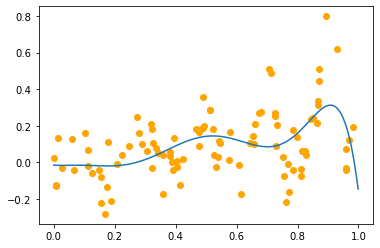

In [13]:
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape arrays
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define model
model = GaussianProcessRegressor()
model.fit(X,y)
# plot the surrogate function
plot(X, y, model)

In [14]:
# The plot resembles a crude version of the underlying 
# non-noisy objective function, importantly with a peak
# around 0.9 where we know the true maxima is located.

In [15]:
# Next we need a sampling strategy for surrogate 
# function
# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each 
    # sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]

In [16]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate 
    # function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:,0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

In [17]:
# perform the optimization process
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print(f"x = {x}, f() = {est}, actual = {actual}")
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X,y)

x = 0.9189430428480589, f() = [[0.30891642]], actual = 0.7676774687759049
x = 0.9167962126458283, f() = [[0.35869789]], actual = 0.7207111701483786
x = 0.9159568867824537, f() = [[0.39361954]], actual = 0.8329129326040698
x = 0.9133844869904141, f() = [[0.43253326]], actual = 0.8171319491936195
x = 0.8827785022974539, f() = [[0.425107]], actual = 0.6688071035703193
x = 0.9054990969131768, f() = [[0.47704029]], actual = 0.7934470405186769
x = 0.9126317775919568, f() = [[0.50084066]], actual = 0.7908533622175301
x = 0.8949115545810369, f() = [[0.50387001]], actual = 0.7398284442911978
x = 0.9143130876998083, f() = [[0.53306675]], actual = 0.8621684103737011
x = 0.915290314439581, f() = [[0.55196142]], actual = 0.9542580375261214
x = 0.9098970343890895, f() = [[0.57451916]], actual = 0.8599610786308327
x = 0.9118090991161923, f() = [[0.58973932]], actual = 0.7192746861146897
x = 0.911142326462315, f() = [[0.59606409]], actual = 0.7209554676969838
x = 0.44072257660312486, f() = [[0.1389094

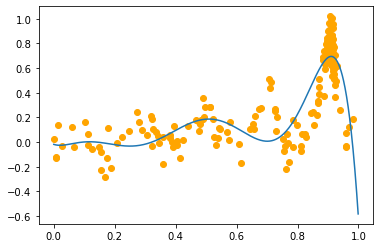

Best Result: x = [0.90721116], y = [1.0202037]


In [18]:
# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print(f"Best Result: x = {X[ix]}, y = {y[ix]}")